In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *

In [33]:
# Load MNIST data
(x_train, y_train), (x_test, _) = mnist.load_data()

# Normalize data and flatten images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Verification subset
y = y_train[:500]
X = x_train[:500]
X = X[np.argsort(y)]

In [35]:
def plot_correlation_matrices(X, L):
    Xcorr = np.corrcoef(X)
    Lcorr = np.corrcoef(L)
    error = np.abs(Xcorr - Lcorr)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

    axs[0].set_title("Input")
    axs[0].imshow(Xcorr)

    axs[1].set_title("Latent")
    axs[1].imshow(Lcorr)

    axs[2].set_title("Absolute errors")
    axs[2].imshow(error)
    print(f"MAE: {np.mean(error)}")



In [36]:
def autoencoder(layers = [784], activations = "linear", optimizer = "adam", loss = "mse"):
    inputs = Input(shape=(layers[0],))
    encode = Sequential([Dense(layer, activations) for layer in layers], name="encoder")(inputs)
    decode = Sequential([Dense(layer, activations) for layer in reversed(layers)])(encode)
    model = Model(inputs, decode)
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Some sanity checks

In [37]:
hyperparameters = dict(epochs=5, batch_size=256, shuffle=True, verbose=0, validation_data=(x_test, x_test))

### Identity memorization

In [38]:
linear_identity = autoencoder(layers = [784, 784])
linear_identity.fit(x_train, x_train, **hyperparameters).history["loss"][-1]

0.31621819734573364

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.08901713898711044


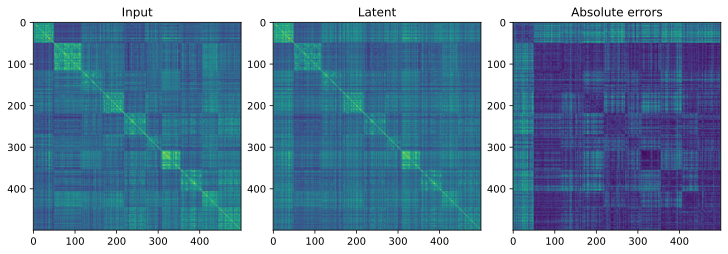

In [39]:
L = linear_identity.get_layer("encoder").predict(X)
plot_correlation_matrices(X, L)

### Linear encoder

In [40]:
linear_encoder20 = autoencoder(layers = [784, 20])
linear_encoder20.fit(x_train, x_train, **hyperparameters).history["loss"][-1]

0.025158336386084557

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 0.1385148535856403


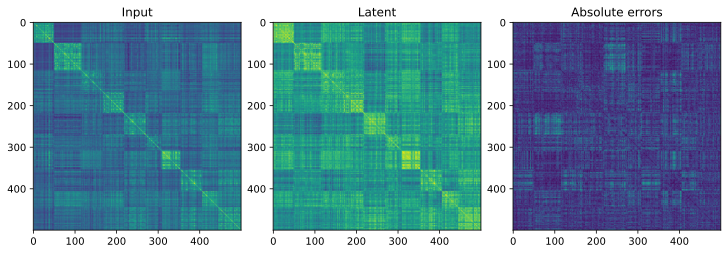

In [42]:
L = linear_encoder20.get_layer("encoder").predict(X)
plot_correlation_matrices(X, L)

### Non-linear encoder

In [43]:
encoder20 = autoencoder(layers = [784, 392, 20], activations="tanh")
encoder20.fit(x_train, x_train, **hyperparameters).history["loss"][-1]

0.028024300932884216

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.3325126734768677


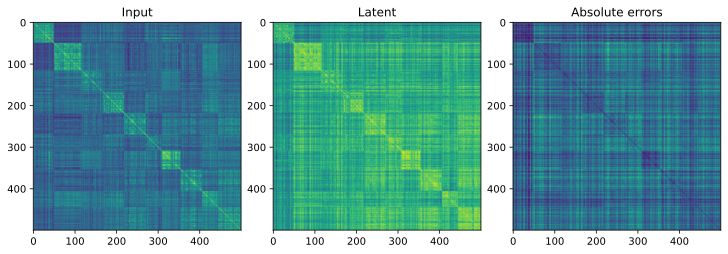

In [44]:
L = encoder20.get_layer("encoder").predict(X)
plot_correlation_matrices(X, L)

### PCA

MAE: 0.25816657850658054


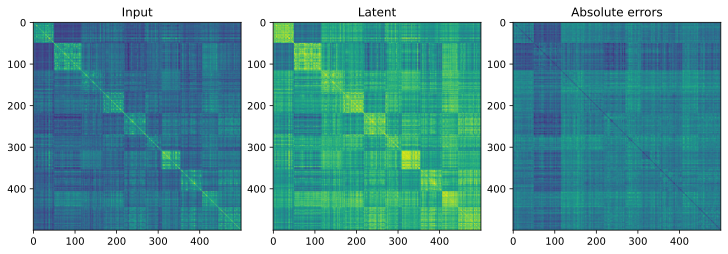

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(StandardScaler().fit_transform(x_train))
plot_correlation_matrices(X, pca.transform(X))

# Explicit correlation optimization

In [46]:
def correlation(matrix):
    # same as numpy.corrcoef but for tensorflow
    means = tf.reduce_mean(matrix, axis=1, keepdims=True)
    diff = matrix - means
    dot_products = tf.matmul(diff, diff, transpose_b=True)
    norms = tf.norm(diff, axis=1, keepdims=True)
    return dot_products / tf.matmul(norms, norms, transpose_b=True)

def correlation_loss(X, Y):
    return tf.reduce_mean((correlation(X) - correlation(Y))**2)

In [48]:
encoder20 = autoencoder(layers = [784, 392, 20], activations="tanh", loss=correlation_loss)
encoder20.fit(x_train, x_train, **hyperparameters).history["loss"][-1]

0.006751981098204851

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 0.060859602343520336


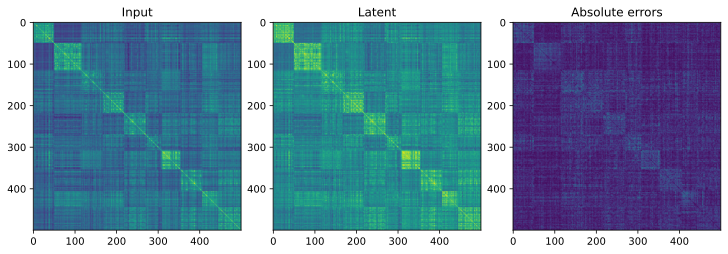

In [50]:
# beats the linear encoders out of the box
L = encoder20.predict(X)
plot_correlation_matrices(X, L)

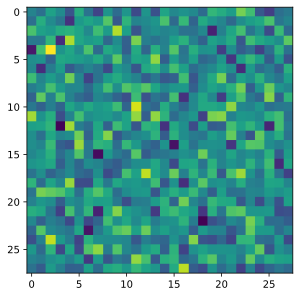

In [51]:
# latent representation is as blobby as was to be expected :^)
plt.imshow(np.reshape(L[0], (28, 28)))

# Simple encoder only architecture

In [52]:
latent_dim = 20
model = Sequential([
    Input(shape=(784,)),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(latent_dim, activation="tanh"),
])

model.compile(optimizer="adam", loss=correlation_loss)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │        32,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,836 (198.58 KB)

 Trainable params: 50,836 (198.58 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(x_train, x_train, epochs=15, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.0095 - val_loss: 0.0071
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 12/15
235/235 ━━━━━━━━━━

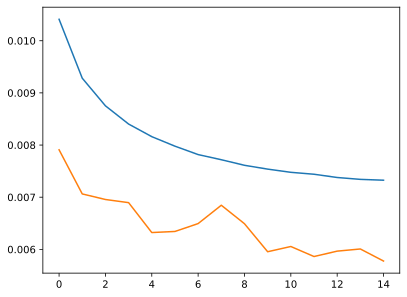

In [55]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAE: 0.057212430237218614


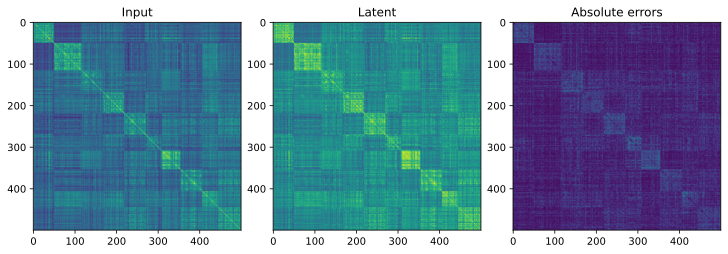

In [56]:
L = model.predict(X)
plot_correlation_matrices(X, L)